# 데이터 준비와 확인

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
from konlpy.tag import Mecab

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# 데이터 로더 구성

In [2]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)
print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(X_train), len(X_test)))

훈련 샘플 개수: 146182, 테스트 개수: 49157


In [3]:
print(X_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
라벨:  0
1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  17


In [4]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [5]:
print(index_to_word[1])     # 'the' 가 출력됩니다. 
#print(word_to_index['the'])  # 1 이 출력됩니다.

<BOS>


In [6]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [7]:
print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0


# 모델 구성을 위한 데이터 분석 및 가공   
## max값 확인하기

In [8]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96938143432699
문장길이 최대 :  116
문장길이 표준편차 :  12.843571939469296
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


# pre로 paddig 하기 

In [9]:
x_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

x_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

print(x_train.shape)

(146182, 41)


# 1-D CNN 모델 설계

In [10]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 16   # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9

# 1-D CNN validation set 설정

In [11]:
# validation set 30000건 분리
x_val = x_train[:30000]   
y_val = y_train[:30000]

# validation set을 제외한 나머지 116182건
partial_x_train = x_train[30000:]  
partial_y_train = y_train[30000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(116182, 41)
(116182,)


# 1-D CNN 모델 학습 및 테스트셋으로 평가

In [12]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=15  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/15
227/227 [==============================] - 5s 24ms/step - loss: 0.4736 - accuracy: 0.7789 - val_loss: 0.3526 - val_accuracy: 0.8455
Epoch 2/15
227/227 [==============================] - 1s 5ms/step - loss: 0.3267 - accuracy: 0.8608 - val_loss: 0.3401 - val_accuracy: 0.8529
Epoch 3/15
227/227 [==============================] - 1s 5ms/step - loss: 0.2953 - accuracy: 0.8770 - val_loss: 0.3388 - val_accuracy: 0.8545
Epoch 4/15
227/227 [==============================] - 1s 5ms/step - loss: 0.2689 - accuracy: 0.8903 - val_loss: 0.3405 - val_accuracy: 0.8555
Epoch 5/15
227/227 [==============================] - 1s 5ms/step - loss: 0.2392 - accuracy: 0.9060 - val_loss: 0.3523 - val_accuracy: 0.8534
Epoch 6/15
227/227 [==============================] - 1s 5ms/step - loss: 0.2069 - accuracy: 0.9213 - val_loss: 0.3746 - val_accuracy: 0.8474
Epoch 7/15
227/227 [==============================] - 1s 5ms/step - loss: 0.1741 - accuracy: 0.9374 - val_loss: 0.4143 - val_accuracy: 0.8431
Epoch

In [13]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.8173 - accuracy: 0.8146
[0.8173345327377319, 0.814594030380249]


# GlobalMaxPooling1D() 모델 설계
words 리스트를 이쓴데 어케만드냐면 불용 다 제거 후 토큰화하고 리스트에 어펜드하면 순소가 생기는데 빈도가 높은거부터 순서가 생김 앞에를 자름

In [14]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 4   # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 4)           40000     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 4)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 40,049
Trainable params: 40,049
Non-trainable params: 0
_________________________________________________________________


# GlobalMaxPooling1D() validation set 설정

In [15]:
# validation set 30000건 분리
x_val = x_train[:30000]   
y_val = y_train[:30000]

# validation set을 제외한 나머지 116182건
partial_x_train = x_train[30000:]  
partial_y_train = y_train[30000:]

print(partial_x_train.shape)
print(partial_y_train.shape)


(116182, 41)
(116182,)


# GlobalMaxPooling1D() 모델 학습 및 테스트셋으로 평가

In [16]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=15  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/15
227/227 [==============================] - 1s 3ms/step - loss: 0.6590 - accuracy: 0.6285 - val_loss: 0.5938 - val_accuracy: 0.7606
Epoch 2/15
227/227 [==============================] - 1s 3ms/step - loss: 0.5409 - accuracy: 0.7908 - val_loss: 0.5012 - val_accuracy: 0.8041
Epoch 3/15
227/227 [==============================] - 1s 3ms/step - loss: 0.4672 - accuracy: 0.8254 - val_loss: 0.4560 - val_accuracy: 0.8194
Epoch 4/15
227/227 [==============================] - 1s 3ms/step - loss: 0.4229 - accuracy: 0.8418 - val_loss: 0.4305 - val_accuracy: 0.8253
Epoch 5/15
227/227 [==============================] - 1s 3ms/step - loss: 0.3925 - accuracy: 0.8520 - val_loss: 0.4166 - val_accuracy: 0.8290
Epoch 6/15
227/227 [==============================] - 1s 3ms/step - loss: 0.3701 - accuracy: 0.8601 - val_loss: 0.4087 - val_accuracy: 0.8303
Epoch 7/15
227/227 [==============================] - 1s 3ms/step - loss: 0.3532 - accuracy: 0.8652 - val_loss: 0.4046 - val_accuracy: 0.8301
Epoch 

In [17]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 1s - loss: 0.4206 - accuracy: 0.8237
[0.4205586910247803, 0.8236873745918274]


# RNN 모델 설계

In [18]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = keras.Sequential()
# [[YOUR CODE]]
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(16))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 16)                2112      
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 162,257
Trainable params: 162,257
Non-trainable params: 0
_________________________________________________________________


# RNN validation set 설정

In [19]:
# validation set 30000건 분리
x_val = x_train[:30000]   
y_val = y_train[:30000]

# validation set을 제외한 나머지 116182건
partial_x_train = x_train[30000:]  
partial_y_train = y_train[30000:]

print(partial_x_train.shape)
print(partial_y_train.shape)


(116182, 41)
(116182,)


# RNN 모델 학습 및 테스트셋으로 평가

In [20]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=15  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/15
227/227 [==============================] - 2s 7ms/step - loss: 0.4835 - accuracy: 0.7831 - val_loss: 0.3594 - val_accuracy: 0.8455
Epoch 2/15
227/227 [==============================] - 1s 6ms/step - loss: 0.3400 - accuracy: 0.8556 - val_loss: 0.3450 - val_accuracy: 0.8512
Epoch 3/15
227/227 [==============================] - 1s 6ms/step - loss: 0.3191 - accuracy: 0.8657 - val_loss: 0.3445 - val_accuracy: 0.8520
Epoch 4/15
227/227 [==============================] - 1s 6ms/step - loss: 0.3052 - accuracy: 0.8731 - val_loss: 0.3447 - val_accuracy: 0.8530
Epoch 5/15
227/227 [==============================] - 1s 6ms/step - loss: 0.2933 - accuracy: 0.8780 - val_loss: 0.3509 - val_accuracy: 0.8520
Epoch 6/15
227/227 [==============================] - 1s 6ms/step - loss: 0.2802 - accuracy: 0.8840 - val_loss: 0.3628 - val_accuracy: 0.8457
Epoch 7/15
227/227 [==============================] - 1s 6ms/step - loss: 0.2687 - accuracy: 0.8898 - val_loss: 0.3557 - val_accuracy: 0.8504
Epoch 

In [21]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4476 - accuracy: 0.8391
[0.44761577248573303, 0.8391277194023132]


---
정확도가 CNN이 제일 낮게, RNN이 제일 높게 나왔다. 정확도가 높은 RNN을 그래프화하여 확인하고, 제일 낮은 모델과 높은 모델에 Word2Vec(워드벡터)을 적용해 보았다. 

# RNN LOSS, Accuracy 그래프 시각화

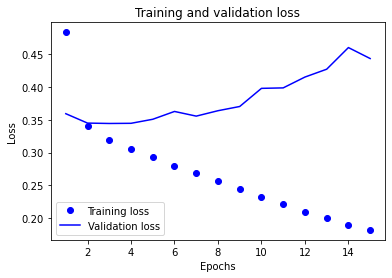

In [22]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

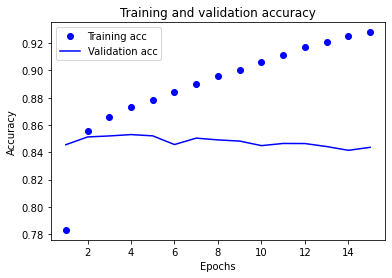

In [23]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Word2Vec 설계

In [24]:
from gensim.models import KeyedVectors
import os
import gensim

#word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko.bin'
ko_model = gensim.models.Word2Vec.load('./aiffel/sentiment_classification/ko.bin')
word2vec = ko_model

# 자체학습 word2vec

In [25]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec_ko.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [26]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

In [27]:
word_vectors.similar_by_word("사랑")

[('상영관', 0.9601520299911499),
 ('호불호', 0.9553101062774658),
 ('잠기', 0.9512739181518555),
 ('~~!!!', 0.9505072832107544),
 ('데요', 0.9473187923431396),
 ('레전드', 0.9468851685523987),
 ('사로잡', 0.943214476108551),
 ('^.^', 0.938183069229126),
 ('으뜸', 0.9370978474617004),
 ('소장', 0.9353660941123962)]

# 사전학습 word2vec

In [28]:
ko_model = gensim.models.Word2Vec.load('./aiffel/sentiment_classification/ko.bin')
word2vec = ko_model

In [29]:
# 메모리를 다소 많이 소비하는 작업이니 유의해 주세요.
word2vec.similar_by_word("사랑")

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  


[('슬픔', 0.7216663360595703),
 ('행복', 0.6759077310562134),
 ('절망', 0.6468985676765442),
 ('기쁨', 0.6458414793014526),
 ('이별', 0.6334798336029053),
 ('추억', 0.6320937871932983),
 ('인생', 0.6216273307800293),
 ('애정', 0.6206068992614746),
 ('연인', 0.6186063289642334),
 ('유혹', 0.5965287685394287)]

#### 내가 만든 자체학습word2vec은 완전 엉뚱한 단어가 나오는데 다운받은 사전학습word2vec은 슬픔 행복 등등 관련있는 단어가 나왔다.

# word2dec 설계

In [30]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]
        
print("ok")

ok


/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


# CNN + Word2Vec 

In [31]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 35, 16)            22416     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [32]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=15  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/15
227/227 [==============================] - 11s 49ms/step - loss: 0.5471 - accuracy: 0.7111 - val_loss: 0.4524 - val_accuracy: 0.7877
Epoch 2/15
227/227 [==============================] - 8s 35ms/step - loss: 0.3946 - accuracy: 0.8243 - val_loss: 0.3811 - val_accuracy: 0.8311
Epoch 3/15
227/227 [==============================] - 8s 35ms/step - loss: 0.3353 - accuracy: 0.8561 - val_loss: 0.3561 - val_accuracy: 0.8455
Epoch 4/15
227/227 [==============================] - 8s 35ms/step - loss: 0.2967 - accuracy: 0.8769 - val_loss: 0.3549 - val_accuracy: 0.8471
Epoch 5/15
227/227 [==============================] - 8s 34ms/step - loss: 0.2690 - accuracy: 0.8908 - val_loss: 0.3605 - val_accuracy: 0.8471
Epoch 6/15
227/227 [==============================] - 8s 35ms/step - loss: 0.2456 - accuracy: 0.9027 - val_loss: 0.3726 - val_accuracy: 0.8462
Epoch 7/15
227/227 [==============================] - 8s 35ms/step - loss: 0.2239 - accuracy: 0.9133 - val_loss: 0.3835 - val_accuracy: 0.844

In [33]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.6684 - accuracy: 0.8273
[0.6684115529060364, 0.8272880911827087]


# RNN + Word2Vec

In [34]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.LSTM(64))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                67840     
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 2,068,369
Trainable params: 2,068,369
Non-trainable params: 0
_________________________________________________________________


In [35]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
227/227 [==============================] - 9s 38ms/step - loss: 0.4659 - accuracy: 0.7730 - val_loss: 0.3645 - val_accuracy: 0.8397
Epoch 2/10
227/227 [==============================] - 10s 45ms/step - loss: 0.3385 - accuracy: 0.8528 - val_loss: 0.3381 - val_accuracy: 0.8522
Epoch 3/10
227/227 [==============================] - 10s 46ms/step - loss: 0.2952 - accuracy: 0.8758 - val_loss: 0.3255 - val_accuracy: 0.8595
Epoch 4/10
227/227 [==============================] - 10s 45ms/step - loss: 0.2665 - accuracy: 0.8904 - val_loss: 0.3255 - val_accuracy: 0.8615
Epoch 5/10
227/227 [==============================] - 10s 44ms/step - loss: 0.2435 - accuracy: 0.9013 - val_loss: 0.3276 - val_accuracy: 0.8623
Epoch 6/10
227/227 [==============================] - 11s 46ms/step - loss: 0.2211 - accuracy: 0.9115 - val_loss: 0.3415 - val_accuracy: 0.8599
Epoch 7/10
227/227 [==============================] - 10s 45ms/step - loss: 0.2002 - accuracy: 0.9210 - val_loss: 0.3473 - val_accuracy: 

In [36]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4576 - accuracy: 0.8503
[0.45762088894844055, 0.8502756357192993]


# LOSS, Accuracy 그래프 시각화

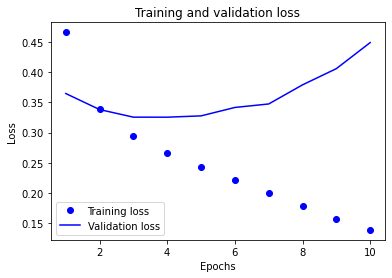

In [37]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

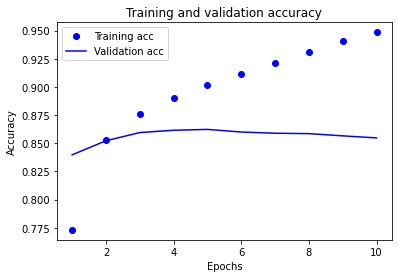

In [38]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [39]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 200)


# 마치며..      
## 루브릭 평가문항   

1. 다양한 방법으로 Text Classification 태스크를 성공적으로 구현하였다. 3가지 이상의 모델이 성공적으로 시도됨

2. gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다. gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 적절히 분석함

3. 한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다. 네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성함   
---
#### CNN accuracy : 0.8146   
#### RNN : accuracy: 0.8391   
#### Maxpooling accuracy: 0.8237
#### CNN + word2vec accuracy: 0.8273   
#### RNN + word2vec accurac었: 0.8503 
CNN과 RNN 눌다 word2vec을 적용했을 때 정확도가 향상되었고, RNN에 word2vec을 적용 했을 때 85% 이상의 정확도를 달성하였다. gensim을 활용하여 나만의 word2vec을 만들어 보았고 유사도를 확인했다. 자체학습과 사전학습의 임베딩의 큰 차이가 있었다. RNN그래프와 RNN+word2vec그래프를 비교해 보았을 땐 전체적으로 모양은 비슷했지만 RNN만 쓴 그래프가 좀 더 taining과 validation의 격차가 없었다. 하지만 RNN + woed2Vec 정확도가 85% 이상 달성했다.